# Piece-wise linear potential 1 - background plots and power spectrum

This is the first in a series of notebooks which will run importance sampling for the Piece-wise linear potential. It is commended the reading is familair with
- [Importance sampling](https://arxiv.org/abs/2206.11234).
- How to simulate the linear Sasaki-Mukhanov mode equation in inflation. 
- The [PyFPT user guides](https://github.com/Jacks0nJ/PyFPT/tree/main/User%20guides).

These Notebooks are simply meant to make all of the 2D results reproducible and are minimal in details.

In this notebook the background dynamics will be simulated and the power spectrum found.

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

from scipy.interpolate import CubicSpline
from scipy.integrate import odeint
from scipy.integrate import RK45
from scipy.optimize import root
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from timeit import default_timer as timer

## The potential

In [2]:
def potential(phi):
    if phi > phi_star:
        return V_0 + A_plus*(phi - phi_star)
    elif phi <= phi_star:
        return V_0 + A_minus*(phi - phi_star)

    
def potential_dif(phi):
    if phi > phi_star:
        return A_plus
    elif phi <= phi_star:
        return A_minus

def potential_ddif(phi):
    return 0.

def V_prime_by_V(phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$

In [3]:
pi_num = np.pi

A_plus = 10**-14
A_minus = A_plus*(10**-3)
cmb_power_spectrum = 2*10**-9
V_0 = (12*cmb_power_spectrum*(pi_num*A_plus)**2)**(1/3)
H_0 = (V_0/3)**(1/2)

# Background simulation
Let's simulate background dynamics. Due to the transition, one either has to do a piece-wise simulation, or choose custom time steps. The later is done here.

Need to estimate the correct starting position to get $\sim 20$ e-folds of slow roll before the transition.

In [4]:
from scipy.integrate import quad
from scipy.optimize import root

# This equations assume slow-roll throughout
def slow_roll_N(phi_in, phi_end):
    def integrand(phi):
        return potential(phi)/potential_dif(phi)
    N, _ = quad(integrand, phi_end, phi_in)
    return N

def root_find_phi_in(phi):
    return slow_roll_N(phi, phi_star) - N_star

phi_star = 1.
N_star = 26.
phi_in_guess = (A_plus/V_0)*N_star + phi_star
sol_root = root(root_find_phi_in, phi_in_guess)
phi_CMB_in = float(sol_root.x)

Now define the equation of motion

In [5]:
def klien_gordon(vec, N):
    phi, pi = vec
    dpi_by_dN = -(3 - 0.5*pi**2)*(pi + V_prime_by_V(phi))
    return [pi, dpi_by_dN]

Let's use slow roll at NLO to set the initial conditions with maximum accuracy.

In [6]:
def hubble_param_LO_1(phi):
    return 0.5*(potential_dif(phi)/potential(phi))**2

def hubble_param_LO_2(phi):
    return 2*( (potential_dif(phi)/potential(phi))**2\
              - potential_ddif(phi)/potential(phi) )

def hubble_param_NLO_1(phi):
    return hubble_param_LO_1(phi)*(1 - hubble_param_LO_2(phi)/3)

def dpi_by_dN_NLO(phi):
    return -(2*hubble_param_NLO_1(phi))**0.5

Now simulate the background

In [7]:
N_values = np.linspace(0, N_star + 25, 800)
N_values_detailed = np.linspace(N_star-2, N_star+6, 200)
N_values_detailed = np.linspace(N_star-0.1, N_star+0.1, 50)
N_values = np.concatenate((N_values, N_values_detailed))
N_values = np.sort(N_values)

phi_0 = phi_CMB_in
dpi_by_dN_0 = dpi_by_dN_NLO(phi_0)
initial_state = [phi_0, dpi_by_dN_0]
sol = odeint(klien_gordon, initial_state, N_values)
phi_values = sol[:, 0]
phi_diff_values = sol[:, 1]
phi_end_true = sol[-1, 0]
N_end = N_values[-1]

Now we have the general sim, now let's find when it should end and re-simulate, ending at that value.

In [8]:
def hubble_param_1_func(dpi_by_dN):
    return (dpi_by_dN**2)/2 

def hubble_func(phi, pi):
    H_squared = 2*potential(phi)/(6-pi**2)
    return H_squared**0.5

def hubble_param_2_func(phi, pi):
    epsilon_H = hubble_param_1_func(pi)
    V_prime_by_V_value =  V_prime_by_V(phi)
    return 2*epsilon_H - V_prime_by_V_value*(6-pi**2)/pi - 6

In [9]:
def nu_sqaured_func(N):
    epsilon2 = epsilon2_interpolation(N, 0)
    epsilon1 = epsilon1_interpolation(N, 0)
    epsilon2_derivative = epsilon2_interpolation(N, 1)
    return 9/4 - epsilon1 + (3/2)*epsilon2 - (1/2)*epsilon1*epsilon2 + (epsilon2**2)/4\
        + epsilon2_derivative/2

In [10]:
hubble_param_values = np.array([hubble_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])
epsilon1_values = np.array([hubble_param_1_func(dpi_by_dN) for dpi_by_dN in sol[:, 1]])
epsilon2_values = np.array([hubble_param_2_func(sol[i, 0], sol[i, 1]) for i in range(len(sol[:, 0]))])

# interpolation
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [11]:
nu_squared_values = np.array([nu_sqaured_func(N_values[i]) for i in range(len(N_values))])

nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

In [12]:
N_for_plotting_logic = (N_values>15) & (N_values<35)

Now let's plot what the Hubble flow parameters and $\nu^2$ is doing

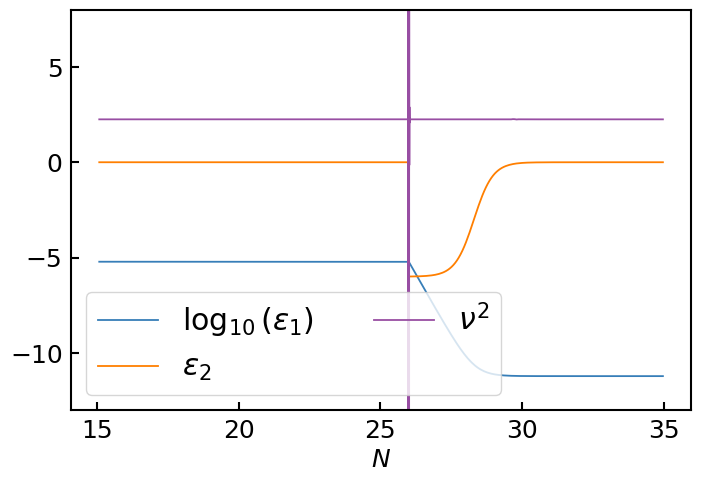

<Figure size 800x520 with 0 Axes>

In [13]:
plt.plot(N_values[N_for_plotting_logic], np.log10(epsilon1_values[N_for_plotting_logic]),
         label=r"$\log_{10}{(\epsilon_{1})}$")
plt.plot(N_values[N_for_plotting_logic], epsilon2_values[N_for_plotting_logic], label=r"$\epsilon_{2}$")
plt.plot(N_values[N_for_plotting_logic], nu_squared_values[N_for_plotting_logic], label=r"$\nu^2$")
plt.xlabel(r"$N$")
plt.ylim(top=8, bottom=-13)
plt.legend(ncol=2)
plt.show()
plt.clf()

**This is just for mostly demonstration. We will often use analytical expressions for the above curves for accuracy**

While there is clearly a period of ultra-slow roll, what is its precise duration? Let's find out using standard root-finding techniques and interpolation.

In [14]:
def root_finding_epsilon2(N_guess, epsilon2_chosen=-3):
    def epsilon2_value_diff(N_epsilon2_time):
        return epsilon2_interpolation(N_epsilon2_time) - epsilon2_chosen
    sol_epsilon2_time = root(epsilon2_value_diff, N_guess)
    N_epsilon2_time = sol_epsilon2_time.x
    return float(N_epsilon2_time)

In [15]:
N_usr_start_guess = N_values[epsilon2_values<-3][0]
N_usr_end_guess = N_values[epsilon2_values<-3][-1]

N_usr_start = root_finding_epsilon2(N_usr_start_guess)
N_usr_end = root_finding_epsilon2(N_usr_end_guess)

print("Ultra-slow roll started at")
print(N_usr_start)
print("and ended at")
print(N_usr_end)

Ultra-slow roll started at
26.000001745817695
and ended at
28.302282891541452


### Now let's save this 

In [16]:
data_dict = {}
data_dict["N"] = N_values
data_dict["phi"] = phi_values
data_dict["phi_N_diff"] = phi_diff_values
data_dict["H"] = hubble_param_values
data_dict["epsilon1"] = epsilon1_values
data_dict["epsilon2"] = epsilon2_values
data_dict["nu_squared"] = nu_squared_values

data_pandas = pd.DataFrame(data_dict)

data_pandas.to_csv("piece_wise_linear_dynamics_dynamics"+".csv")

## Mode simulation

To find the power spectrum, normally we need to be able to simulare a linear mode from deep inside the horizon until Hubble-crossing until the end of inflation. But due to the analytical nature of this model, we can solve the mode equation analoytically. 

In [17]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

## $\delta \phi_k$

In [18]:
def analytical_delta_phi(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1 = complex(1, k_eta)*np.exp(complex(0, -k_eta))
    term2 = complex(1, -k_eta)*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)

    delta_phi = k_term*(alpha*term1 - beta*term2)
    return delta_phi

def analytical_delta_phi_N_derivative(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    epsilon = epsilon_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1_deriv = (k**2)*comoving_time*np.exp(complex(0, -k_eta))
    term2_deriv = (k**2)*comoving_time*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)


    delta_phi_N_derivative = k_term*(alpha*term1_deriv - beta*term2_deriv)/aH
    return delta_phi_N_derivative

In fact it is more accurate to use the analytical expressions

In [19]:
def analytical_epsilon_1(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_1 = (A_plus**2)/(18*(H**4))
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_1 = ((Delta_A*(comoving_time*k_transition)**3 + A_minus)**2)/(18*(H**4))
    return epsilon_1

def analytical_epsilon_2(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_2 = 0.
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_2 =\
            (-6*Delta_A*(comoving_time*k_transition)**3)/(Delta_A*(comoving_time*k_transition)**3 + A_minus)
    return epsilon_2

# Power spectrum
Let us use the analytical formula to find the phase-space

In [20]:
def power_spectrum_func(k, R):
    return (np.abs(R)**2)*(k**3)/(2*np.pi**2)

In [21]:
a_in = 1
N_values_for_plot = np.linspace(N_star - np.log(4*10**3), N_star + np.log(4*10**3), 1000)
N_eval = N_end-5  # This is to prevent a numerical accuracy error.

power_specrum_values = np.zeros(len(N_values_for_plot))
for j in range(len(N_values_for_plot)):
    N_mode_exit = N_values_for_plot[j]
    # Find when this mode left the horizon

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    delta_phi = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    R = delta_phi/np.sqrt(2*analytical_epsilon_1(N_eval, N_end, N_star, A_plus, A_minus))
    power_specrum_values[j] = power_spectrum_func(k, R)

In [22]:
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))

k_values_plot_normalised = aH_interpolation(N_values_for_plot)/aH_interpolation(N_star)

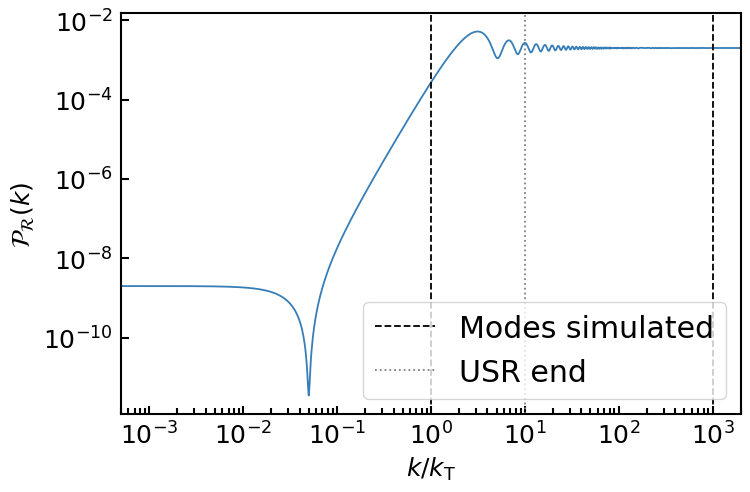

<Figure size 800x520 with 0 Axes>

In [23]:
plt.plot(k_values_plot_normalised, power_specrum_values)
plt.axvline(x=1, linestyle="dashed", color="k")
plt.axvline(x=1000, linestyle="dashed", color="k", label="Modes simulated")
plt.axvline(x=aH_interpolation(N_usr_end)/aH_interpolation(N_star), linestyle="dotted",
            color="gray", label="USR end")
plt.yscale("log")
plt.xscale("log")
plt.xlim(left=0.5*10**-3, right=2*10**3)
plt.ylabel(r"$\mathcal{P}_\mathcal{R}(k)$")
plt.xlabel(r"$k/k_{\rm T}$")
plt.legend()
plt.show()
plt.clf()